## Detecting change in urban extent

## Background
<p>The rate at which cities and towns grow, or the urbanisation rate, is a key measure of a city's long-term viability. Rapid, unplanned urbanization can have negative social, economic, and environmental consequences due to inadequate and overcrowded infrastructure and services, which cause traffic congestion, aggravate air pollution, and lead in a housing shortage.
To address the effects of rapid urbanisation, the first necessity is to correctly and routinely monitor urban expansion in order to track urban development through time. Earth observation databases, such as those provided by the Digital Earth Pacific platform, are a cost-effective and accurate way of obtaining information.</p>

## Description 

<p>This notebook  will evaluate the shift in urban extent between a baseline period and a more recent period using Landsat. The difference in urban extent (in square kilometers) between the two periods is estimated, as well as a map displaying urban growth hotspots.</p>

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
# change the coordinates to suit your study area
area_of_interest = {
        "type": "Polygon",
        "coordinates": [
         [
            [
              177.44258880615234,
              -17.802467027976665
            ],
            [
              177.5358009338379,
              -17.802467027976665
            ],
            [
              177.5358009338379,
              -17.714186776357895
            ],
            [
              177.44258880615234,
              -17.714186776357895
            ],
            [
              177.44258880615234,
              -17.802467027976665
            ]
          ]

        ]
      }

In [3]:
def LoadImage(year, cloudcover = 0):
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(
        collections=["landsat-8-c2-l2"],
        intersects=area_of_interest,
        datetime=f"{year}-01-01/{year}-12-31",
        query={"eo:cloud_cover": {"gt": cloudcover}},
    )
    items = list(search.get_items())
    # Check how many items were returned
    return sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]
    
      
def RGBvisualiser(least_cloudy_item):
    asset_hrefs = [
        find_asset_by_band_common_name(least_cloudy_item, "red").href,
        find_asset_by_band_common_name(least_cloudy_item, "green").href,
        find_asset_by_band_common_name(least_cloudy_item, "blue").href,
    ]
   
    imagelist = [pc.sign(asset_href) for asset_href in asset_hrefs]
    bands = [read_band(href) for href in imagelist]
    multiband_data = np.stack(bands)
    rescaled = multiband_data.astype(float)
    min_value, max_value = rescaled.min(), rescaled.max()
    rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
    byte_data = rescaled.astype("ubyte")   
    return Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))
    
    
def get_band(ds, band_name):
    return read_band(pc.sign(find_asset_by_band_common_name(ds, band_name).href)).astype(float)

def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")
    
def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)
    
def computeENDISI(blue,swir_diff,mndwi,alpha):
    return ((blue-alpha)*(swir_diff + mndwi**2)) / ((blue+alpha)*(swir_diff + mndwi**2))

def computeMNDWI(green,swir):
    return (green - swir) / (green + swir)

def compute_swir_diff(swir1,swir2):
    return swir1 / swir2

def compute_alpha(blue,swiff_diff,mndwi):
    return (2*np.mean(blue)) / (np.mean(swiff_diff) + np.mean(mndwi**2))

## Calculate Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) 
<img src="MNDWI.png" width=500 >

In [4]:
years = [2015, 2016, 2017, 2018, 2019]
ENDISI = []
for year in years :
    Image = LoadImage(year)
    
    red = get_band(Image, 'red')

    blue= get_band(Image, 'blue')

    swir16 = get_band(Image, 'swir16')

    swir22 = get_band(Image, 'swir22')

    green = get_band(Image, 'green')
    
    
    swir_diff  =compute_swir_diff(swir16 ,swir22 )
    mndwi  = computeMNDWI(green  , swir16 )
    alpha  = compute_alpha(blue ,swir_diff ,mndwi )
    
    
    endisi  = computeENDISI(blue ,swir_diff ,mndwi ,alpha )
    
    ENDISI.append([year,endisi])
    

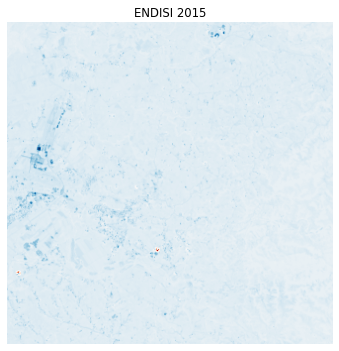

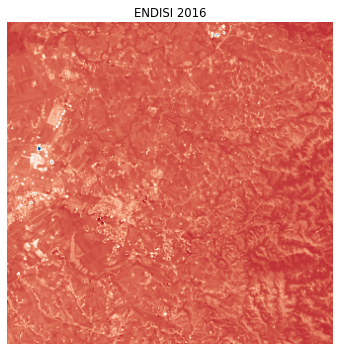

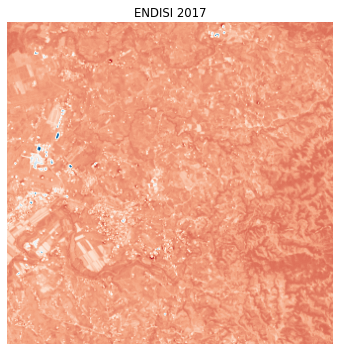

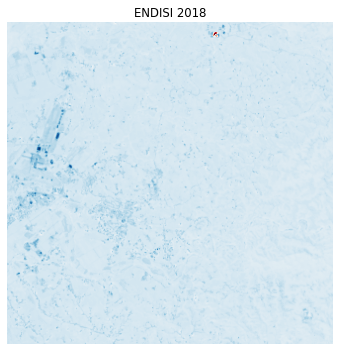

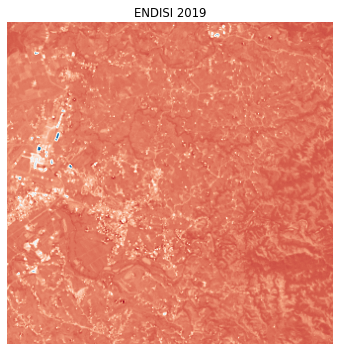

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
for ends in ENDISI :
    w = ends[1].shape[0]
    h = ends[1].shape[1]
    dpi = 70
    fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.title(f"ENDISI {ends[0]}")
    plt.imshow(ends[1], cmap="RdBu");
    
#     plt.colorbar(cax=ax)
#     plt.show()
# plt.colorbar(cax=ax)

## Calculate urban extent

<p>The ENDISI arrays must be thresholded to specify the urban extension. Values over this level will be labeled as 'Urban,' while those below it will be omitted from the urban extent. This threshold can be set in a variety of ways, including explicitly defining it (e.g. threshold=-0.1). The Otsu technique is used to automatically threshold the picture in the example below.</p>

## Apply the threshold

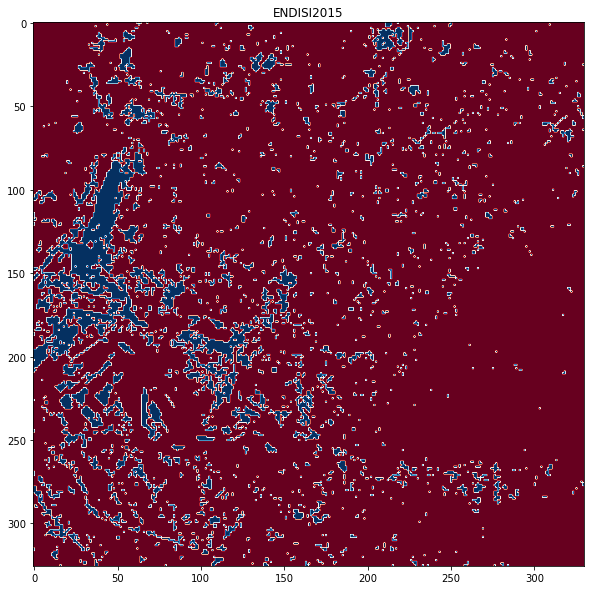

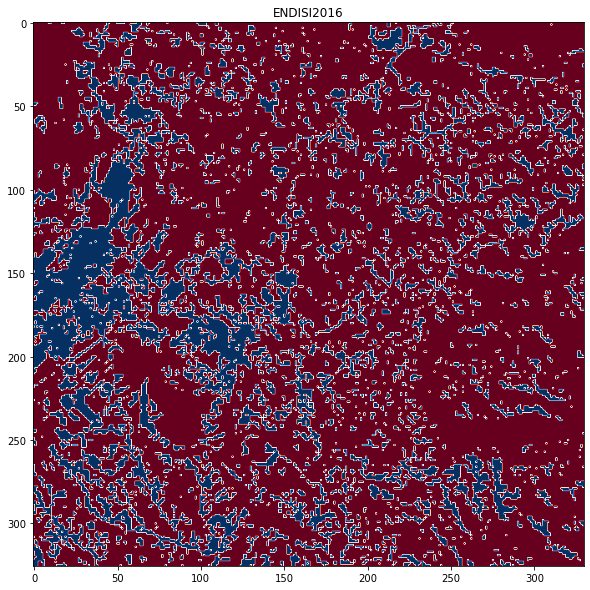

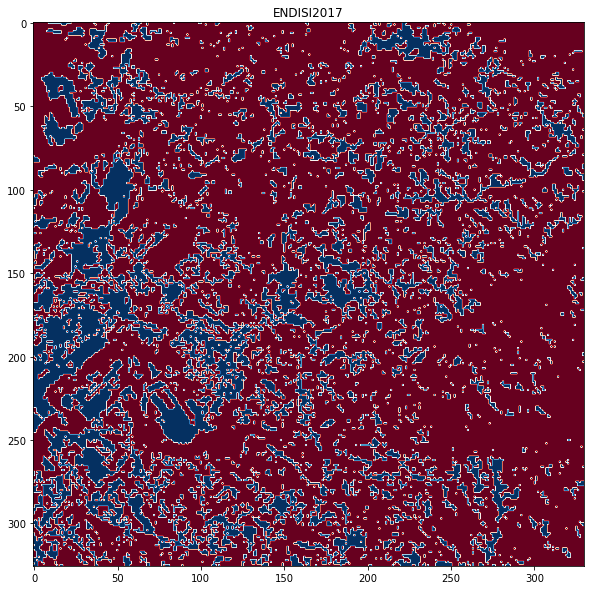

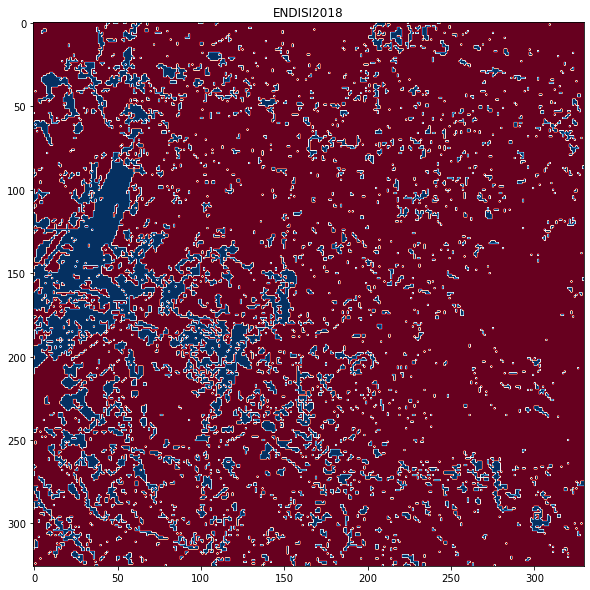

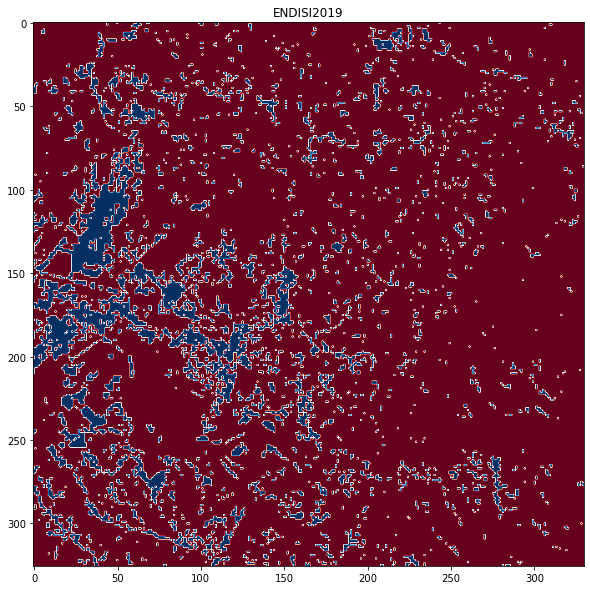

In [6]:
urban_list=[]
for ends in ENDISI :
    from skimage.filters import threshold_otsu
    threshold = threshold_otsu(ends[1])
    
    endisi = np.array(ends[1])
    
    urban_area = np.greater(endisi,threshold).astype(int)
    urban_list.append([ends[0], urban_area])
    fig = figure(figsize=(10, 10), frameon=True)
    plt.imshow(urban_area, cmap="RdBu")
    plt.title(f"ENDISI{ends[0]}")
#     plt.legend(add_colorbar=True)
        

In [7]:
pixel_length =30  # in metres
area_per_pixel = pixel_length**2 / 1000**2

In [8]:
urban_area_km2=[]
for urban in urban_list :
    
    urban_area_km2.append([urban[0], (np.sum(urban[1])+area_per_pixel)])
print(urban_area_km2)

[[2015, 11265.0009], [2016, 24195.0009], [2017, 25434.0009], [2018, 16433.0009], [2019, 12978.0009]]


In [9]:
year = []
area = []

for aa in urban_area_km2:
    area.append(aa[1])
    year.append(aa[0])

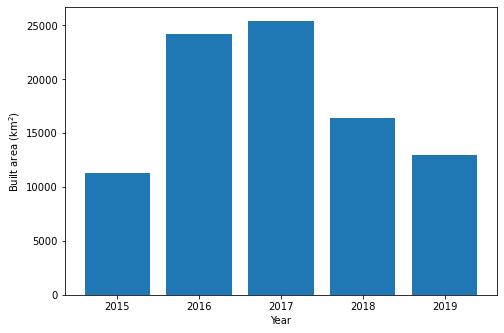

Urban extent in 2015:  11265.001 km2
Urban extent in 2016:  24195.001 km2
Urban extent in 2017:  25434.001 km2
Urban extent in 2018:  16433.001 km2
Urban extent in 2019:  12978.001 km2


In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
years = year
areas = area
ax.bar(years,areas)
ax.set_xlabel("Year")
ax.set_ylabel("Built area (km$^2$)");
plt.show()

for y in urban_area_km2:
    print(f'Urban extent in {str(y[0])}:  {round(float(y[1]),3)} km2')

## Urban growth hotspots